# Single-Head Flash Attention Benchmarks
This notebook benchmarks the scalar softmax attention expression $\operatorname{softmax}(KQ^T)V$ for a **single** sequence/head using reference PyTorch code, `torch.nn.functional.scaled_dot_product_attention`, simplified FlashAttention v1/v2 style kernels, and a fused Triton implementation.


In [1]:
import math
from typing import Callable, Dict

import torch
import torch.nn.functional as F

import triton
import triton.testing
import triton.language as tl

DEVICE = triton.runtime.driver.active.get_active_torch_device()
torch.backends.cuda.matmul.allow_tf32 = True


We generate random single-head inputs of shape `(seq_len, dim)` on the active CUDA device and define several attention implementations that we want to compare. Keeping everything single-head makes it easier to focus on the arithmetic cost of softmax(KQᵀ)V without extra tensor reshaping overhead.


In [2]:
def make_attention_inputs(seq_len: int, dim: int, dtype=torch.float16):
    q = torch.randn((seq_len, dim), device=DEVICE, dtype=dtype)
    k = torch.randn((seq_len, dim), device=DEVICE, dtype=dtype)
    v = torch.randn((seq_len, dim), device=DEVICE, dtype=dtype)
    return q, k, v


def _causal_mask(scores: torch.Tensor):
    seq_len = scores.shape[-2]
    idx = torch.arange(seq_len, device=scores.device)
    mask = idx.view(-1, 1) < idx.view(1, -1)
    return scores.masked_fill(mask, float('-inf'))


def attention_naive(q: torch.Tensor, k: torch.Tensor, v: torch.Tensor, causal: bool = False) -> torch.Tensor:
    scale = 1.0 / math.sqrt(q.shape[-1])
    logits = torch.matmul(q, k.transpose(-2, -1)) * scale
    if causal:
        logits = _causal_mask(logits)
    probs = torch.softmax(logits, dim=-1)
    return torch.matmul(probs, v)


In [12]:
FLASH_BLOCK_Q = 128
FLASH_BLOCK_K = 128
TRITON_BLOCK_M = 128
TRITON_BLOCK_N = 64
TRITON_BLOCK_D = 64

@triton.jit
def _flash_v2_kernel(
    Q, K, V, sm_scale,  
    Out,
    stride_qm, stride_qk, 
    stride_kn, stride_kk,
    stride_vn, stride_vk,
    stride_om, stride_on,
    seq_len,
    IS_CAUSAL: tl.constexpr,
    BLOCK_M: tl.constexpr, BLOCK_N: tl.constexpr, BLOCK_D: tl.constexpr
):
    # FlashAttention-2 Logic (unchanged parallelism)
    
    start_m = tl.program_id(0)
    
    offs_m = start_m * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_n = tl.arange(0, BLOCK_N)
    offs_d = tl.arange(0, BLOCK_D)
    
    q_ptrs = Q + (offs_m[:, None] * stride_qm + offs_d[None, :] * stride_qk)
    out_ptrs = Out + (offs_m[:, None] * stride_om + offs_d[None, :] * stride_on)
    
    q = tl.load(q_ptrs, mask=offs_m[:, None] < seq_len, other=0.0)
    
    m_i = tl.zeros([BLOCK_M], dtype=tl.float32) - float("inf")
    l_i = tl.zeros([BLOCK_M], dtype=tl.float32)
    acc = tl.zeros([BLOCK_M, BLOCK_D], dtype=tl.float32)
    
    lo = 0
    hi = seq_len
    if IS_CAUSAL:
        hi = (start_m + 1) * BLOCK_M
        
    for start_n in range(lo, hi, BLOCK_N):
        k_ptrs = K + ((start_n + offs_n)[None, :] * stride_kn + offs_d[:, None] * stride_kk)
        v_ptrs = V + ((start_n + offs_n)[:, None] * stride_vn + offs_d[None, :] * stride_vk)
        
        k = tl.load(k_ptrs, mask=(start_n + offs_n)[None, :] < seq_len, other=0.0)
        v = tl.load(v_ptrs, mask=(start_n + offs_n)[:, None] < seq_len, other=0.0)
        
        qk = tl.dot(q, k)
        qk *= sm_scale 
        
        if IS_CAUSAL:
            curr_m = offs_m[:, None]
            curr_n = start_n + offs_n[None, :]
            qk = tl.where(curr_n <= curr_m, qk, float("-inf"))
            
        m_curr = tl.max(qk, 1)
        m_new = tl.maximum(m_i, m_curr)
        
        p = tl.exp(qk - m_new[:, None])
        alpha = tl.exp(m_i - m_new)
        
        acc = acc * alpha[:, None] + tl.dot(p.to(tl.float16), v)
        l_i = l_i * alpha + tl.sum(p, 1)
        m_i = m_new

    acc = acc / l_i[:, None]
    tl.store(out_ptrs, acc.to(tl.float16), mask=offs_m[:, None] < seq_len)

def flash_attention_v2(q: torch.Tensor, k: torch.Tensor, v: torch.Tensor, causal: bool = False) -> torch.Tensor:
    # Call Triton V2 Kernel with parallel grid
    seq_len, dim = q.shape
    out = torch.empty_like(q)
    scale = 1.0 / math.sqrt(dim)
    grid = (triton.cdiv(seq_len, TRITON_BLOCK_M), )
    
    _flash_v2_kernel[grid](
        q, k, v, scale, out,
        q.stride(0), q.stride(1),
        k.stride(0), k.stride(1),
        v.stride(0), v.stride(1),
        out.stride(0), out.stride(1),
        seq_len,
        IS_CAUSAL=causal,
        BLOCK_M=TRITON_BLOCK_M, BLOCK_N=TRITON_BLOCK_N, BLOCK_D=TRITON_BLOCK_D
    )
    return out

@triton.jit
def _naive_matmul_kernel(
    A, B, C,
    stride_am, stride_ak,
    stride_bk, stride_bn,
    stride_cm, stride_cn,
    M, N, K,
    BLOCK_M: tl.constexpr, BLOCK_N: tl.constexpr, BLOCK_K: tl.constexpr,
):
    pid_m = tl.program_id(0)
    pid_n = tl.program_id(1)
    
    offs_m = pid_m * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_n = pid_n * BLOCK_N + tl.arange(0, BLOCK_N)
    offs_k = tl.arange(0, BLOCK_K)
    
    a_ptrs = A + (offs_m[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = B + (offs_k[:, None] * stride_bk + offs_n[None, :] * stride_bn)
    
    acc = tl.zeros((BLOCK_M, BLOCK_N), dtype=tl.float32)
    
    for k in range(0, K, BLOCK_K):
        a = tl.load(a_ptrs, mask=(offs_m[:, None] < M) & (k + offs_k[None, :] < K), other=0.0)
        b = tl.load(b_ptrs, mask=(k + offs_k[:, None] < K) & (offs_n[None, :] < N), other=0.0)
        acc += tl.dot(a, b)
        a_ptrs += BLOCK_K * stride_ak
        b_ptrs += BLOCK_K * stride_bk
        
    c_ptrs = C + (offs_m[:, None] * stride_cm + offs_n[None, :] * stride_cn)
    tl.store(c_ptrs, acc.to(tl.float16), mask=(offs_m[:, None] < M) & (offs_n[None, :] < N))

@triton.jit
def _fused_softmax_score_kernel(
    Q, K, P,
    stride_qm, stride_qk,
    stride_kn, stride_kk, 
    stride_pm, stride_pn,
    M, N, D,
    sm_scale,
    IS_CAUSAL: tl.constexpr,
    BLOCK_M: tl.constexpr, BLOCK_N: tl.constexpr, BLOCK_D: tl.constexpr
):
    pid_m = tl.program_id(0)
    offs_m = pid_m * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_d = tl.arange(0, BLOCK_D)
    
    q_ptrs = Q + (offs_m[:, None] * stride_qm + offs_d[None, :] * stride_qk)
    q = tl.load(q_ptrs, mask=offs_m[:, None] < M, other=0.0)
    
    # --- Pass 1: Max ---
    m_i = tl.zeros([BLOCK_M], dtype=tl.float32) - float("inf")
    
    offs_n = tl.arange(0, BLOCK_N)
    
    for start_n in range(0, N, BLOCK_N):
        k_ptrs = K + ((start_n + offs_n)[:, None] * stride_kn + offs_d[None, :] * stride_kk)
        k_block = tl.load(k_ptrs, mask=(start_n + offs_n)[:, None] < N, other=0.0)
        
        qk = tl.dot(q, tl.trans(k_block))
        qk *= sm_scale
        
        if IS_CAUSAL:
            curr_n = start_n + offs_n[None, :]
            qk = tl.where(curr_n <= offs_m[:, None], qk, float("-inf"))
        else:
             qk = tl.where((start_n + offs_n)[None, :] < N, qk, float("-inf"))
             
        m_i = tl.maximum(m_i, tl.max(qk, 1))
        
    # --- Pass 2: Sum Exp ---
    l_i = tl.zeros([BLOCK_M], dtype=tl.float32)
    
    for start_n in range(0, N, BLOCK_N):
        k_ptrs = K + ((start_n + offs_n)[:, None] * stride_kn + offs_d[None, :] * stride_kk)
        k_block = tl.load(k_ptrs, mask=(start_n + offs_n)[:, None] < N, other=0.0)
        
        qk = tl.dot(q, tl.trans(k_block))
        qk *= sm_scale
        
        if IS_CAUSAL:
            curr_n = start_n + offs_n[None, :]
            qk = tl.where(curr_n <= offs_m[:, None], qk, float("-inf"))
        else:
             qk = tl.where((start_n + offs_n)[None, :] < N, qk, float("-inf"))
             
        p = tl.exp(qk - m_i[:, None])
        l_i += tl.sum(p, 1)

    # --- Pass 3: Compute & Write P ---
    for start_n in range(0, N, BLOCK_N):
        k_ptrs = K + ((start_n + offs_n)[:, None] * stride_kn + offs_d[None, :] * stride_kk)
        k_block = tl.load(k_ptrs, mask=(start_n + offs_n)[:, None] < N, other=0.0)
        
        qk = tl.dot(q, tl.trans(k_block))
        qk *= sm_scale
        
        if IS_CAUSAL:
            curr_n = start_n + offs_n[None, :]
            qk = tl.where(curr_n <= offs_m[:, None], qk, float("-inf"))
        else:
             qk = tl.where((start_n + offs_n)[None, :] < N, qk, float("-inf"))
             
        p = tl.exp(qk - m_i[:, None]) / l_i[:, None]
        
        p_ptrs = P + (offs_m[:, None] * stride_pm + (start_n + offs_n)[None, :] * stride_pn)
        tl.store(p_ptrs, p.to(tl.float16), mask=(offs_m[:, None] < M) & ((start_n + offs_n)[None, :] < N))


def attention_triton(q: torch.Tensor, k: torch.Tensor, v: torch.Tensor, causal: bool = False) -> torch.Tensor:
    # Explicit "Naive in Triton": 
    # 1. P = Softmax(Q @ K.T) [Fused Kernel]
    # 2. O = P @ V [Matmul Kernel]
    
    seq_len, dim = q.shape
    scale = 1.0 / math.sqrt(dim)
    
    # 1. P matrix (NxN) in global memory
    p = torch.empty((seq_len, seq_len), device=q.device, dtype=q.dtype)
    
    BLOCK_M = 128
    BLOCK_N = 64 # Iterating over K
    BLOCK_D = 64
    
    grid_scores = (triton.cdiv(seq_len, BLOCK_M), )
    
    # Pass stride 1 if contig, or real stride.
    # Note: K is passed as (N, D).
    
    _fused_softmax_score_kernel[grid_scores](
        q, k, p,
        q.stride(0), q.stride(1),
        k.stride(0), k.stride(1),
        p.stride(0), p.stride(1),
        seq_len, seq_len, dim,
        scale,
        IS_CAUSAL=causal,
        BLOCK_M=BLOCK_M, BLOCK_N=BLOCK_N, BLOCK_D=BLOCK_D
    )
    
    # 2. O = P @ V
    o = torch.empty_like(q)
    
    # P (MxK) @ V (KxN) -> O (MxN)
    # Here M=seq_len, K=seq_len, N=dim (of value)
    
    # BLOCK_M = 128 (Output M dim)
    # BLOCK_N = 64  (Output N dim -> D=64)
    # BLOCK_K = 128 (Reduct axis -> seq_len). 
    
    BLOCK_M_MATMUL = 128
    BLOCK_N_MATMUL = 64
    BLOCK_K_MATMUL = 64 
    
    grid_matmul = (triton.cdiv(seq_len, BLOCK_M_MATMUL), triton.cdiv(dim, BLOCK_N_MATMUL)) 
    
    _naive_matmul_kernel[grid_matmul](
        p, v, o,
        p.stride(0), p.stride(1),
        v.stride(0), v.stride(1),
        o.stride(0), o.stride(1),
        seq_len, dim, seq_len,
        BLOCK_M=BLOCK_M_MATMUL, BLOCK_N=BLOCK_N_MATMUL, BLOCK_K=BLOCK_K_MATMUL
    )
    
    return o


ATTENTION_LABELS = {
    'naive': 'Naive PyTorch',
    'flash_v2': 'Flash Attention v2',
    'triton': 'Triton With Fusion Only',
}

ATTENTION_IMPLS: Dict[str, Callable[[torch.Tensor, torch.Tensor, torch.Tensor], torch.Tensor]] = {
    'naive': attention_naive,
    'flash_v2': flash_attention_v2,
    'triton': attention_triton,
}

In [13]:
@torch.inference_mode()
def validate_attention_impls(seq_len: int = 512,
                             dim: int = 64,
                             dtype: torch.dtype = torch.float16,
                             causal: bool = False):
    q, k, v = make_attention_inputs(seq_len, dim, dtype)
    reference = attention_naive(q.to(torch.float32), k.to(torch.float32), v.to(torch.float32), causal=causal).to(dtype)
    for name, fn in ATTENTION_IMPLS.items():
        out = fn(q, k, v)
        max_diff = torch.max(torch.abs(out - reference)).item()
        print(f"{name:>10s}: max |diff| = {max_diff:.2e}")


validate_attention_impls()


     naive: max |diff| = 3.97e-04
  flash_v2: max |diff| = 2.44e-04
    triton: max |diff| = 1.22e-04


In [14]:
attention_seq_lens = [128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],
        x_vals=attention_seq_lens,
        x_log=True,
        line_arg='provider',
        line_vals=list(ATTENTION_IMPLS.keys()),
        line_names=[ATTENTION_LABELS[name] for name in ATTENTION_IMPLS.keys()],
        ylabel='ms',
        plot_name='single-head-flash-attention',
        args={'dim': 64, 'dtype': torch.float16},
    ))
def attention_benchmark(seq_len, provider, dim, dtype):
    q, k, v = make_attention_inputs(seq_len, dim, dtype)
    fn = ATTENTION_IMPLS[provider]
    quantiles = [0.5, 0.2, 0.8]
    ms, max_ms, min_ms = triton.testing.do_bench(lambda: fn(q, k, v), quantiles=quantiles)
    return ms, max_ms, min_ms


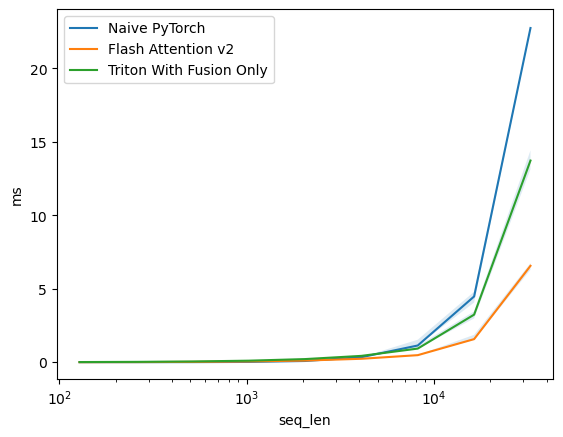

single-head-flash-attention:
   seq_len  Naive PyTorch  Flash Attention v2  Triton With Fusion Only
0    128.0       0.014336            0.013312                 0.022528
1    256.0       0.014336            0.019456                 0.034816
2    512.0       0.017248            0.034816                 0.061440
3   1024.0       0.030720            0.064512                 0.115712
4   2048.0       0.094400            0.123904                 0.224176
5   4096.0       0.351232            0.244736                 0.442368
6   8192.0       1.147904            0.491264                 0.937984
7  16384.0       4.484096            1.582016                 3.248128
8  32768.0      22.746640            6.569984                13.729824


In [15]:
attention_benchmark.run(print_data=True, show_plots=True)
